In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, OptimizerType, Comparator, SamplingMethod, plot_loss_df, set_seeds

In [2]:
latex_var_map = {
    r"J_e": "Je",
    r"J_h": "Jh",
    r"\psi": "psi",
    r"\iota": "iota",
    r"\Phi": "Phi",
    r"\hat{c}_e": "ce",
    r"\hat{c}_h": "ch",

    r"\mu_{ae}": "muae",
    r"\sigma_{ae}": "sigae",
    r"\theta_e": "thetae",
    r"\theta_h": "thetah",
    r"\sigma^{q,k}": "sigqk",
    r"\sigma^{q,a}": "sigqa",
    r"\sigma^{q,k,1}": "sigsigqk",
    r"\sigma^{z,k}": "sigzk",
    r"\sigma^{z,a}": "sigza",
    r"\sigma_e^{J,k}": "sigJe_k",
    r"\sigma_h^{J,k}": "sigJh_k",
    r"\sigma_e^{J,a}": "sigJe_a",
    r"\sigma_h^{J,a}": "sigJh_a",

    r"\zeta_e^k": "zetae_k",
    r"\zeta_e^a": "zetae_a",
    r"\zeta_h^k": "zetah_k",
    r"\zeta_h^a": "zetah_a",
    r"\zeta_e^1": "zetae_1",
    r"\zeta_e^2": "zetae_2",
    r"\zeta_h^1": "zetah_1",
    r"\zeta_h^2": "zetah_2",
    r"\epsilon_e": "epse",
    r"\epsilon_h": "epsh",

    r"\mu^z": "muz",
    r"\mu^q": "muq",
    r"\mu_e^J": "muJe",
    r"\mu_h^J": "muJh",
    r"\mu_e^R": "muRe",
    r"\mu_h^R": "muRh",

    r"\hat{a_e}": "aebar",
    r"a_e": "ae",
    r"a_h": "ah",
    r"\sigma": "sig",
    r"\delta": "delta",
    r"\kappa": "kappa",
    r"\phi": "phi",
    r"\gamma": "gamma",
    r"\rho": "rho",
    r"\lambda_d": "lambdad",
    r"\underline{\chi}": "chi_a",
    r"\chi": "chi",
    r"\bar{z}": "zbar",
}

vars_to_plot = ["q", "thetae", "thetah", "psi", "sigsigqk", "sigqa", "epse", "epsh",
                "zmuz", "zsigzk", "zsigza", "zetae_k", "zetae_a", "zetah_k", "zetah_a"]
plot_args = {
    "q": {"ylabel": r"$q$", "title": r"Price"},
    "thetae": {"ylabel": r"$\theta_e$", "title": r"Portfolio Choice: Experts"},
    "thetah": {"ylabel": r"$\theta_h$", "title": r"Portfolio Choice: Households"},
    "psi": {"ylabel": r"$\psi$", "title": r"Capital Share: Experts"},
    "sigsigqk": {"ylabel": r"$\sigma+\sigma^{q,k}$", "title": r"Price return diffusion (capital shock)"},
    "sigqa": {"ylabel": r"$\sigma^{q,a}$", "title": r"Price return diffusion (productivity shock)"},
    "zmuz": {"ylabel": r"$z\mu^z$", "title": r"Drift of wealth share: Experts"},
    "zsigzk": {"ylabel": r"$z\sigma^{z,k}$", "title": r"Diffusion of wealth share (capital shock)"},
    "zsigza": {"ylabel": r"$z\sigma^{z,a}$", "title": r"Diffusion of wealth share (productivity shock)"},
    "zetae_k": {"ylabel": r"$\zeta_e^k$", "title": r"Experts price of risk: capital shock"},
    "zetae_a": {"ylabel": r"$\zeta_e^a$", "title": r"Experts price of risk: productivity shock"},
    "zetah_k": {"ylabel": r"$\zeta_h^k$", "title": r"Households price of risk: capital shock"},
    "zetah_a": {"ylabel": r"$\zeta_h^a$", "title": r"Households price of risk: productivity shock"}
}

z_min = 0.01
z_max = 0.99
a_min = 0.1
a_max = 0.2
ae_bar = (a_min + a_max) / 2
a_list = [a_min, ae_bar, a_max]
params = {
    "ah": 0.03,
    "sig": 0.1,
    "delta": 0.05,
    "kappa": 5,
    "phi": 0.5,
    "gamma": 5,
    "rho": torch.tensor(0.05),
    "lambdad": 0.03,
    "zbar": 0.1,
    "chi_a": 1,
    "v": 2.5,
    "p": 0.01,
    "fl": a_min,
    "fu": a_max,
    "aebar": ae_bar,
}

base_model_dir = "./models/cd_2d_soft_attention/"

In [3]:
def compute_func(pde_model: PDEModel, a_list, z_min, z_max, vars_to_plot):
    N = 100
    res_dict = {}
    for a in a_list:
        SV = torch.zeros((N, 2), device=pde_model.device)
        SV[:, 0] = torch.linspace(z_min, z_max, N)
        SV[:, 1] = torch.ones((N,)) * a
        x_plot = SV[:, 0].detach().cpu().numpy().reshape(-1)
        for i, sv_name in enumerate(pde_model.state_variables):
            pde_model.variable_val_dict[sv_name] = SV[:, i:i+1]
        pde_model.update_variables(SV)
        res_dict["x_plot"] = x_plot
        for var in vars_to_plot:
            if var in pde_model.variable_val_dict:
                res_dict[f"{var}_{a}"] = pde_model.variable_val_dict[var].detach().cpu().numpy().reshape(-1)
            elif var == "psi":
                res_dict[f"psi_{a}"] = np.ones(N)
    return res_dict

def plot_res(res_dict: dict, plot_args:dict, a_list):
    res_dict = res_dict.copy()
    x_plot = res_dict.pop("x_plot")
    x_label = "Wealth share (z)"
    total_plots = len(plot_args)
    cols = 4
    rows, rem = np.divmod(total_plots, cols)
    if rem > 0:
        rows += 1

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6, rows*6))
    for i, (func_name, plot_arg) in enumerate(plot_args.items()):
        r, c = np.divmod(i, cols)
        curr_ax = axes[r, c] # hopefully we don't have only one row...
        for a in a_list:
            y_vals = res_dict[f"{func_name}_{a}"]
            curr_ax.plot(x_plot, y_vals, label=r"$a_e$={i}".format(i=str(round(a,2))))
        curr_ax.set_xlabel(x_label)
        curr_ax.set_ylabel(plot_arg["ylabel"])
        curr_ax.set_title(plot_arg["title"])
        curr_ax.legend()
    plt.show()

## Region 1
$\psi < 1$

=============================Summary of Model cd2d==============================
Config: {
 "batch_size": 50,
 "num_epochs": 20000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid",
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": true
}
Latex Variable Mapping:
{
 "J_e": "Je",
 "J_h": "Jh",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "Phi",
 "\\hat{c}_e": "ce",
 "\\hat{c}_h": "ch",
 "\\mu_{ae}": "muae",
 "\\sigma_{ae}": "sigae",
 "\\theta_e": "thetae",
 "\\theta_h": "thetah",
 "\\sigma^{q,k}": "sigqk",
 "\\sigma^{q,a}": "sigqa",
 "\\sigma^{q,k,1}": "sigsigqk",
 "\\sigma^{z,k}": "sigzk",
 "\\sigma^{z,a}": "sigza",
 "\\sigma_e^{J,k}": "sigJe_k",
 "\\sigma_h^{J,k}": "sigJh_k",
 "\\sigma_e^{J,a}": "sigJe_a",
 "\\sigma_h^{J,a}": "sigJh_a",
 "\\zeta_e^k": "zetae_k",
 "\\zeta_e^a": "zetae_a",
 "\\zeta_h^k": "zetah_k",
 "\\zet

Total loss: 0.0046: 100%|██████████| 20000/20000 [2:01:49<00:00,  2.74it/s]  


training finished, total time :: 7309.833000421524
Best model saved to ./models/cd_2d_soft_attention//region1_best.pt if valid
Model saved to ./models/cd_2d_soft_attention//region1.pt


C:\Users\User\AppData\Local\Temp\ipykernel_3756\3700970361.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pde_model.load_model(torch.load(f"{base_model_dir}/region1_be

Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_min: 0.0001,
endogvar_q_cond_q_max: 0.0001,
endogvar_psi_cond_psi_min: 0.0000,
endogvar_psi_cond_psi_max: 0.0000,
endogeq_1: 0.0001,
endogeq_2: 0.0008,
hjbeq_1: 0.0005,
hjbeq_2: 0.0002,
total_loss: 0.0158


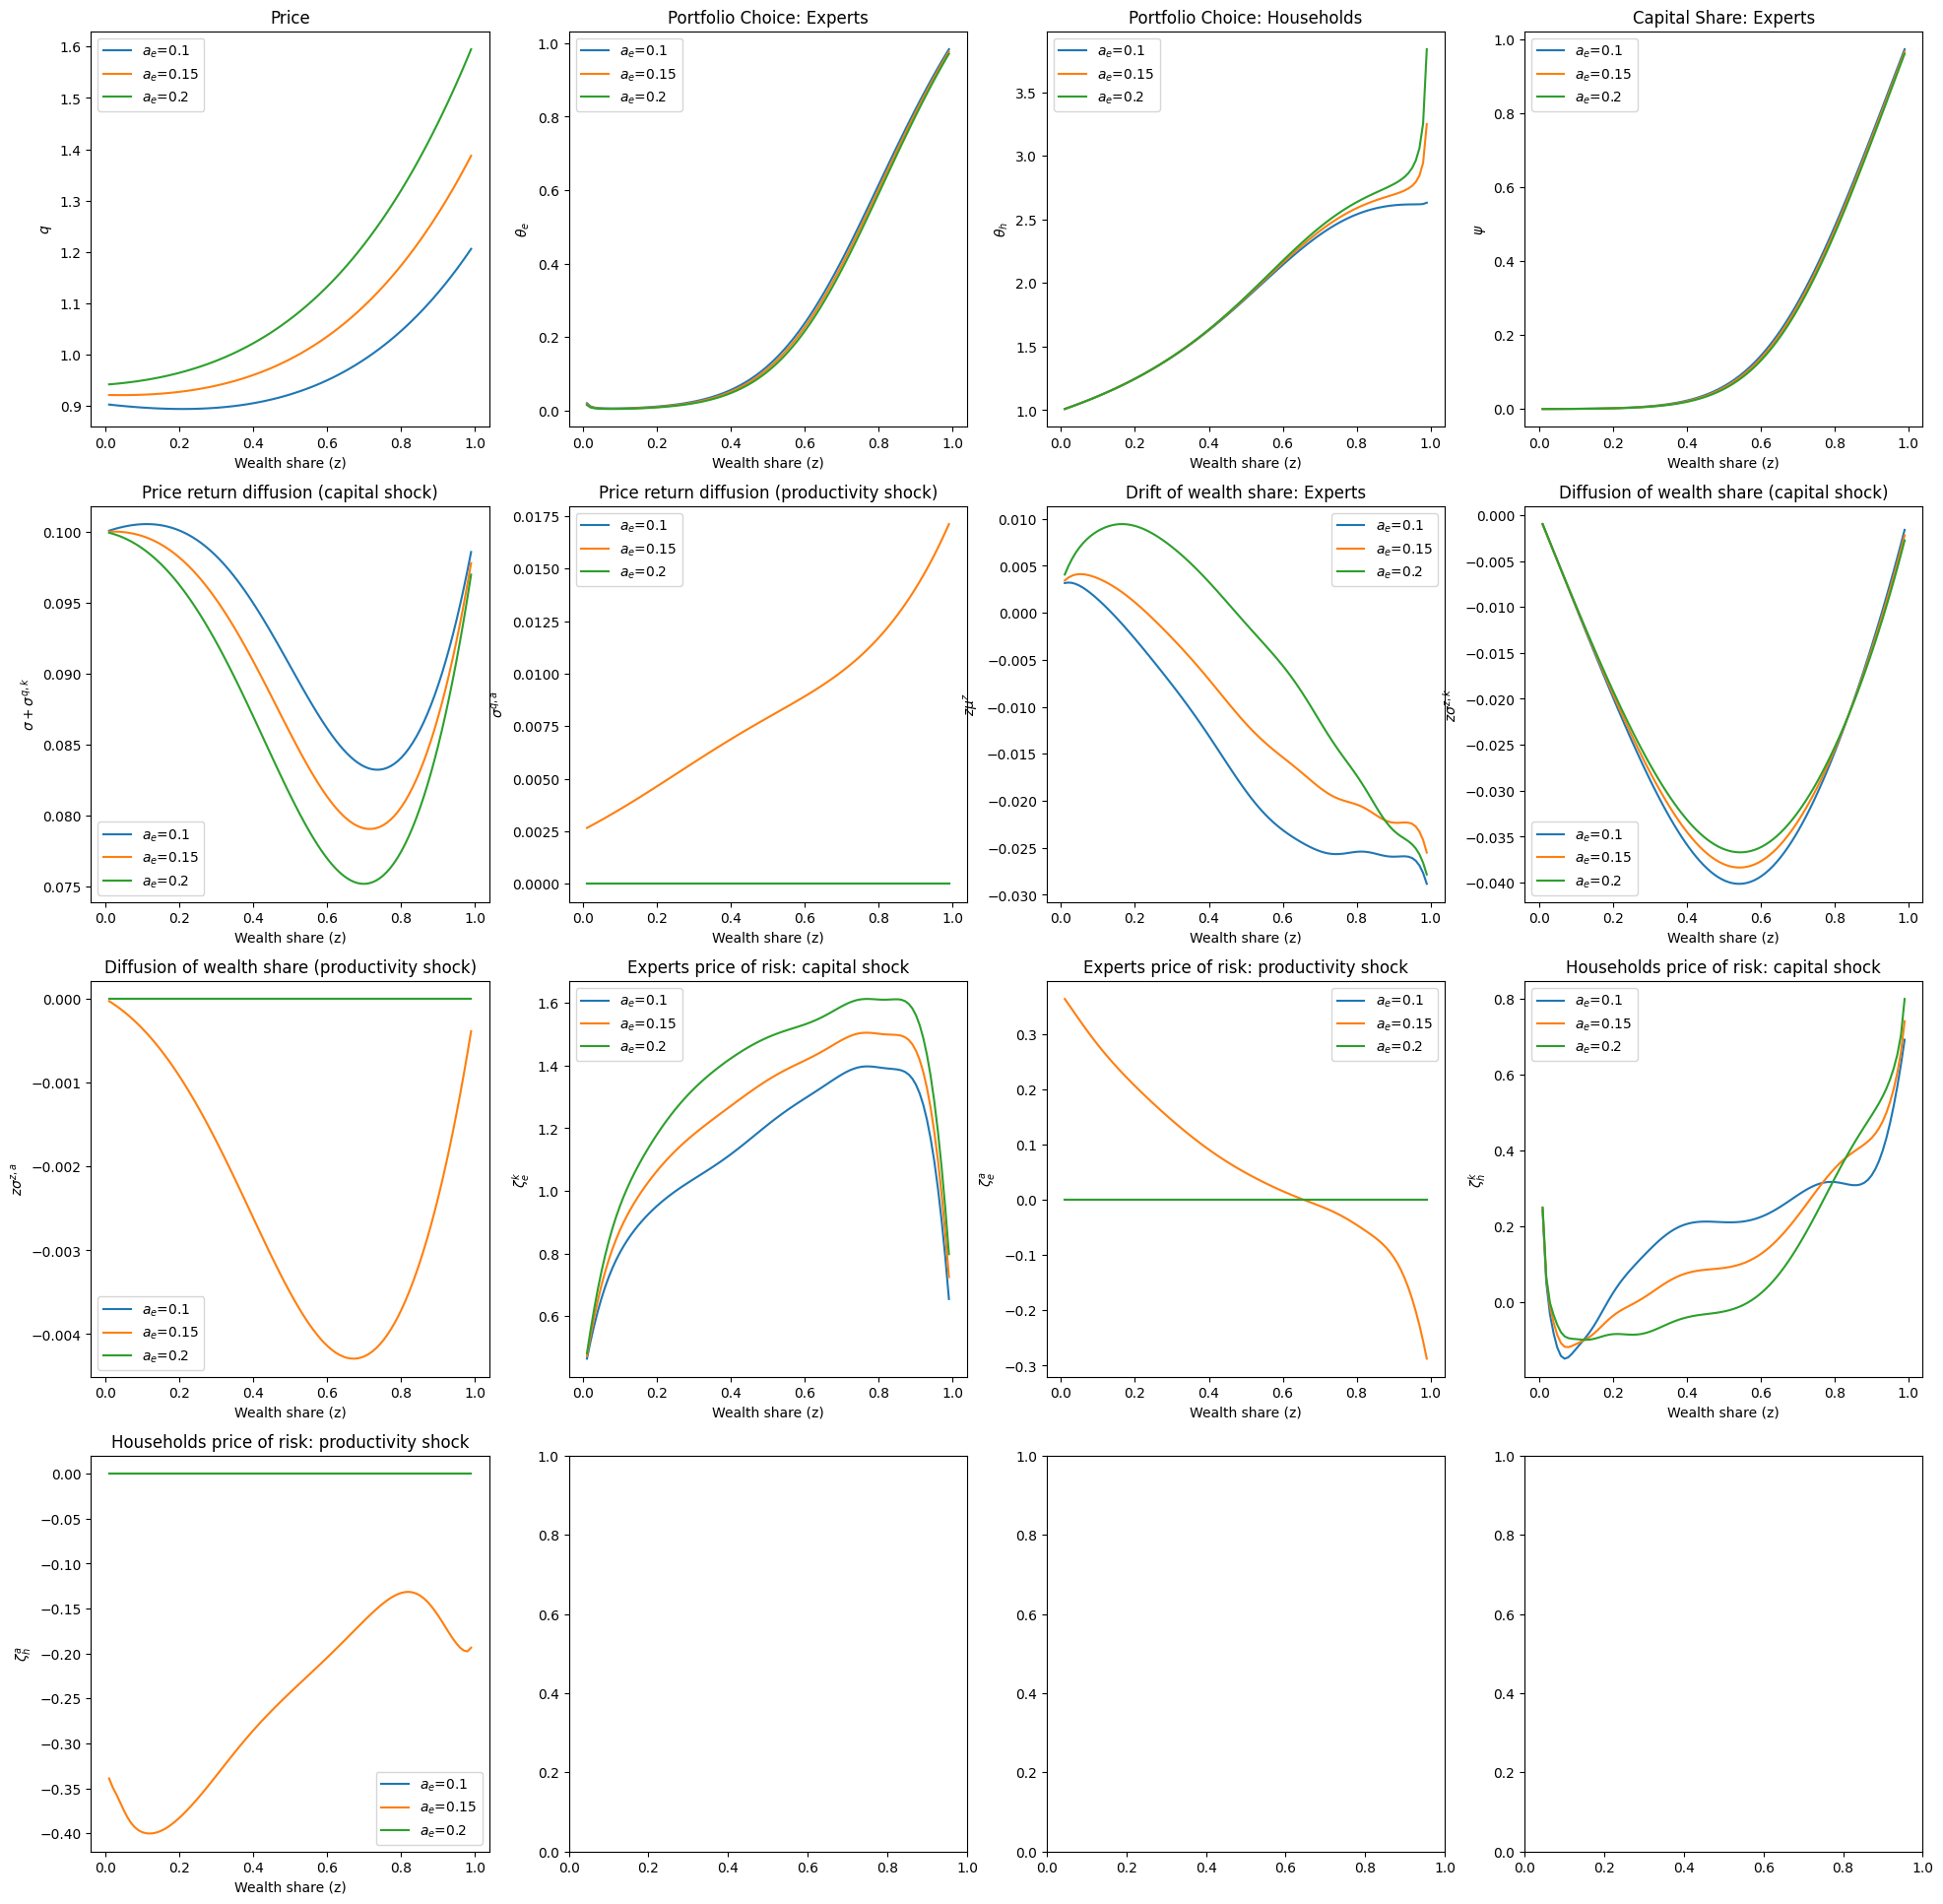

In [4]:
set_seeds(0)
pde_model = PDEModel("cd2d",
                     {"batch_size": 50, "num_epochs": 20000, "optimizer_type": OptimizerType.Adam, "sampling_method": SamplingMethod.FixedGrid,
                      "loss_soft_attention": True},
                     latex_var_map)
pde_model.set_state(["z", "ae"], {"z": [z_min, z_max], "ae": [a_min, a_max]})
pde_model.add_agents(["Je", "Jh"],
                     {"Je": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "Jh": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                     })
pde_model.add_endogs(["q", "psi"],
                     {"q": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "psi": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      })
pde_model.add_params(params)
zero_z = torch.zeros((100, 2), device=pde_model.device)
zero_z[:, 1] = torch.linspace(a_min, a_max, steps=100, device=pde_model.device)
one_z = torch.ones((100, 2), device=pde_model.device)
one_z[:, 1] = torch.linspace(a_min, a_max, steps=100, device=pde_model.device)
pde_model.add_endog_condition("q",
                              "q(SV)",
                              {"SV": zero_z},
                              Comparator.EQ,
                              "(1+kappa*ah)/(1+kappa*rho)", {"rho": params["rho"], "ah": params["ah"], "kappa": params["kappa"]},
                              label="q_min", weight=0.01)
pde_model.add_endog_condition("q",
                              "q(SV)",
                              {"SV": one_z},
                              Comparator.EQ,
                              "(1+kappa*ae)/(1+kappa*rho)", {"rho": params["rho"], "ae": zero_z[:, 1:2], "kappa": params["kappa"]},
                              label="q_max", weight=0.01)
pde_model.add_endog_condition("psi",
                              "psi(SV)",
                              {"SV": zero_z},
                              Comparator.EQ,
                              "0", {},
                              label="psi_min", weight=0.01)
pde_model.add_endog_condition("psi",
                              "psi(SV)",
                              {"SV": one_z},
                              Comparator.EQ,
                              "1", {},
                              label="psi_max", weight=0.01)

pde_model.add_equation(r"$\iota &= \frac{q - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi &= \frac{\log ( q)}{\kappa}$")
pde_model.add_equation(r"$\hat{c}_e &= \rho$")
pde_model.add_equation(r"$\hat{c}_h &= \rho$")
pde_model.add_equation(r"$\mu_{ae} &= p * (\hat{a_e} - a_e)$")
pde_model.add_equation(r"$\sigma_{ae} &= v * (fu - a_e) * (a_e - fl)$")
pde_model.add_equation(r"$\theta_e &= \frac{\underline{\chi} * \psi}{z}$")
pde_model.add_equation(r"$\theta_h &= \frac{1 - \underline{\chi} * \psi}{1 - z}$")
pde_model.add_equation(r"$\sigma^{q,k} &= \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} * \psi - z)} - \sigma$")
pde_model.add_equation(r"$\sigma^{q,a} &= \frac{\frac{1}{q} * \frac{\partial q}{\partial a_e} * \sigma_{ae}}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} * \psi - z)}$")
pde_model.add_equation(r"$\sigma^{q,k,1} &= \sigma + \sigma^{q,k}$")
pde_model.add_equation(r"$\sigma^{z,k} &= \left(\theta_e - 1\right) * \sigma^{q,k,1}$")
pde_model.add_equation(r"$\sigma^{z,a} &= \left(\theta_e - 1\right) * \sigma^{q,a}$")
pde_model.add_equation(r"$\sigma_e^{J,k} &= \frac{1}{J_e} * \frac{\partial J_e}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_h^{J,k} &= \frac{1}{J_h} * \frac{\partial J_h}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_e^{J,a} &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial a_e} * \sigma_{ae} + \frac{\partial J_e}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\sigma_h^{J,a} &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial a_e} * \sigma_{ae} + \frac{\partial J_h}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\zeta_e^k &= -(1-\gamma) * \sigma_e^{J,k} + \sigma^{z,k} + \sigma^{q,k} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_e^a &= -(1-\gamma) * \sigma_e^{J,a} + \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_h^k &= -(1-\gamma) * \sigma_h^{J,k} - \frac{z}{1-z} * \sigma^{z,k} + \sigma^{q,k,1} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_h^a &= -(1-\gamma) * \sigma_h^{J,a} - \frac{z}{1-z} * \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_e^1 &= \zeta_e^k + \phi * \zeta_e^a$")
pde_model.add_equation(r"$\zeta_h^1 &= \zeta_h^k + \phi * \zeta_h^a$")
pde_model.add_equation(r"$\zeta_e^2 &= \zeta_e^a + \phi * \zeta_e^k$")
pde_model.add_equation(r"$\zeta_h^2 &= \zeta_h^a + \phi * \zeta_h^k$")
pde_model.add_equation(r"$\epsilon_e &= \sigma^{q,k,1} * \zeta_e^1 + \sigma^{q,a} * \zeta_e^2$")
pde_model.add_equation(r"$\epsilon_h &= \sigma^{q,k,1} * \zeta_h^1 + \sigma^{q,a} * \zeta_h^2$")
pde_model.add_equation(r"$\mu^z &= \frac{a_e - \iota}{q} - \hat{c}_e+ (\theta_e - 1) * (\sigma^{q,k,1} * (\zeta_e^1 - \sigma^{q,k,1}) + \sigma^{q,a} * (\zeta_e^2 - \sigma^{q,a}) - 2 * \phi * \sigma^{q,k,1} * \sigma^{q,a})+ (1-\underline{\chi}) * (\sigma^{q,k,1} * (\zeta_e^1 - \zeta_h^1) + \sigma^{q,a} * (\zeta_e^2 - \zeta_h^2)) + \frac{\lambda_d}{z} * (\bar{z} - z)$")
pde_model.add_equation(r"$\mu^q &= \frac{1}{q} * \left( \frac{\partial q}{\partial z} * \mu^z * z + \frac{\partial q}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2 q}{\partial z^2} * z^2 * ((\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k} * \sigma^{z,a})\right)+ \frac{1}{q} * \left( \frac{1}{2} * \frac{\partial^2 q}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 q}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a})  * \sigma_{ae} * z\right)$")
pde_model.add_equation(r"$\mu_e^J &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial z} * \mu^z * z + \frac{\partial J_e}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_e}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) \right)+ \frac{1}{J_e} * \left(\frac{1}{2} * \frac{\partial^2 J_e}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_e}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z \right)$")
pde_model.add_equation(r"$\mu_h^J &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial z} * \mu^z * z + \frac{\partial J_h}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_h}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) \right)+ \frac{1}{J_h} * \left(\frac{1}{2} * \frac{\partial^2 J_h}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_h}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z \right)$")
pde_model.add_equation(r"$\mu_e^R &= \frac{a_e - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$\mu_h^R &= \frac{a_h - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$r &= \mu_e^R - \underline{\chi} * \epsilon_e - (1-\underline{\chi}) * \epsilon_h$")
pde_model.add_equation(r"zmuz = z * muz")
pde_model.add_equation(r"zsigzk = z * sigzk")
pde_model.add_equation(r"zsigza = z * sigza")

pde_model.add_endog_equation(r"$\rho * q &= \psi * a_e + (1-\psi) * a_h - \iota$")
pde_model.add_endog_equation(r"$\frac{a_e - a_h}{q} &= \underline{\chi} * (\epsilon_e - \epsilon_h)$")

pde_model.add_hjb_equation(r"$\rho * (\log(\rho) - \log(J_e) + \log(q * z)) + \Phi - \delta - (\gamma - 1) * (\sigma_e^{J,k} * \sigma + \phi * \sigma * \sigma_e^{J,a})-\frac{\gamma}{2} * ((\sigma_e^{J,k})^2 + (\sigma_e^{J,a})^2 + 2*\phi * \sigma_e^{J,k} * \sigma_e^{J,a} + \sigma^2) - \mu_e^J$")
pde_model.add_hjb_equation(r"$\rho * (\log(\rho) - \log(J_h) + \log(q * (1-z))) + \Phi - \delta - (\gamma - 1) * (\sigma_h^{J,k} * \sigma + \phi * \sigma * \sigma_h^{J,a})-\frac{\gamma}{2} * ((\sigma_h^{J,k})^2 + (\sigma_h^{J,a})^2 + 2*\phi * \sigma_h^{J,k} * \sigma_h^{J,a} + \sigma^2) - \mu_h^J$")

print(pde_model)
if not os.path.exists(f"{base_model_dir}/region1.pt"):
    pde_model.train_model(base_model_dir, "region1.pt", True)
    pde_model.load_model(torch.load(f"{base_model_dir}/region1_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{base_model_dir}/region1_best.pt"))
    pde_model.eval_model(True)

res_dict1 = compute_func(pde_model, a_list, z_min, z_max, vars_to_plot)
plot_res(res_dict1, plot_args, a_list)

## Region 2
$\psi = 1$, but $\epsilon_e \geq \epsilon_h$

=============================Summary of Model cd2d==============================
Config: {
 "batch_size": 50,
 "num_epochs": 20000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid",
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": true
}
Latex Variable Mapping:
{
 "J_e": "Je",
 "J_h": "Jh",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "Phi",
 "\\hat{c}_e": "ce",
 "\\hat{c}_h": "ch",
 "\\mu_{ae}": "muae",
 "\\sigma_{ae}": "sigae",
 "\\theta_e": "thetae",
 "\\theta_h": "thetah",
 "\\sigma^{q,k}": "sigqk",
 "\\sigma^{q,a}": "sigqa",
 "\\sigma^{q,k,1}": "sigsigqk",
 "\\sigma^{z,k}": "sigzk",
 "\\sigma^{z,a}": "sigza",
 "\\sigma_e^{J,k}": "sigJe_k",
 "\\sigma_h^{J,k}": "sigJh_k",
 "\\sigma_e^{J,a}": "sigJe_a",
 "\\sigma_h^{J,a}": "sigJh_a",
 "\\zeta_e^k": "zetae_k",
 "\\zeta_e^a": "zetae_a",
 "\\zeta_h^k": "zetah_k",
 "\\zet

Total loss: 0.0001: 100%|██████████| 20000/20000 [1:57:32<00:00,  2.84it/s]  


training finished, total time :: 7052.964406490326
Best model saved to ./models/cd_2d_soft_attention//region2_best.pt if valid
Model saved to ./models/cd_2d_soft_attention//region2.pt


C:\Users\User\AppData\Local\Temp\ipykernel_3756\858605479.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pde_model.load_model(torch.load(f"{base_model_dir}/region2_bes

Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
constraint_1: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
total_loss: 0.0001


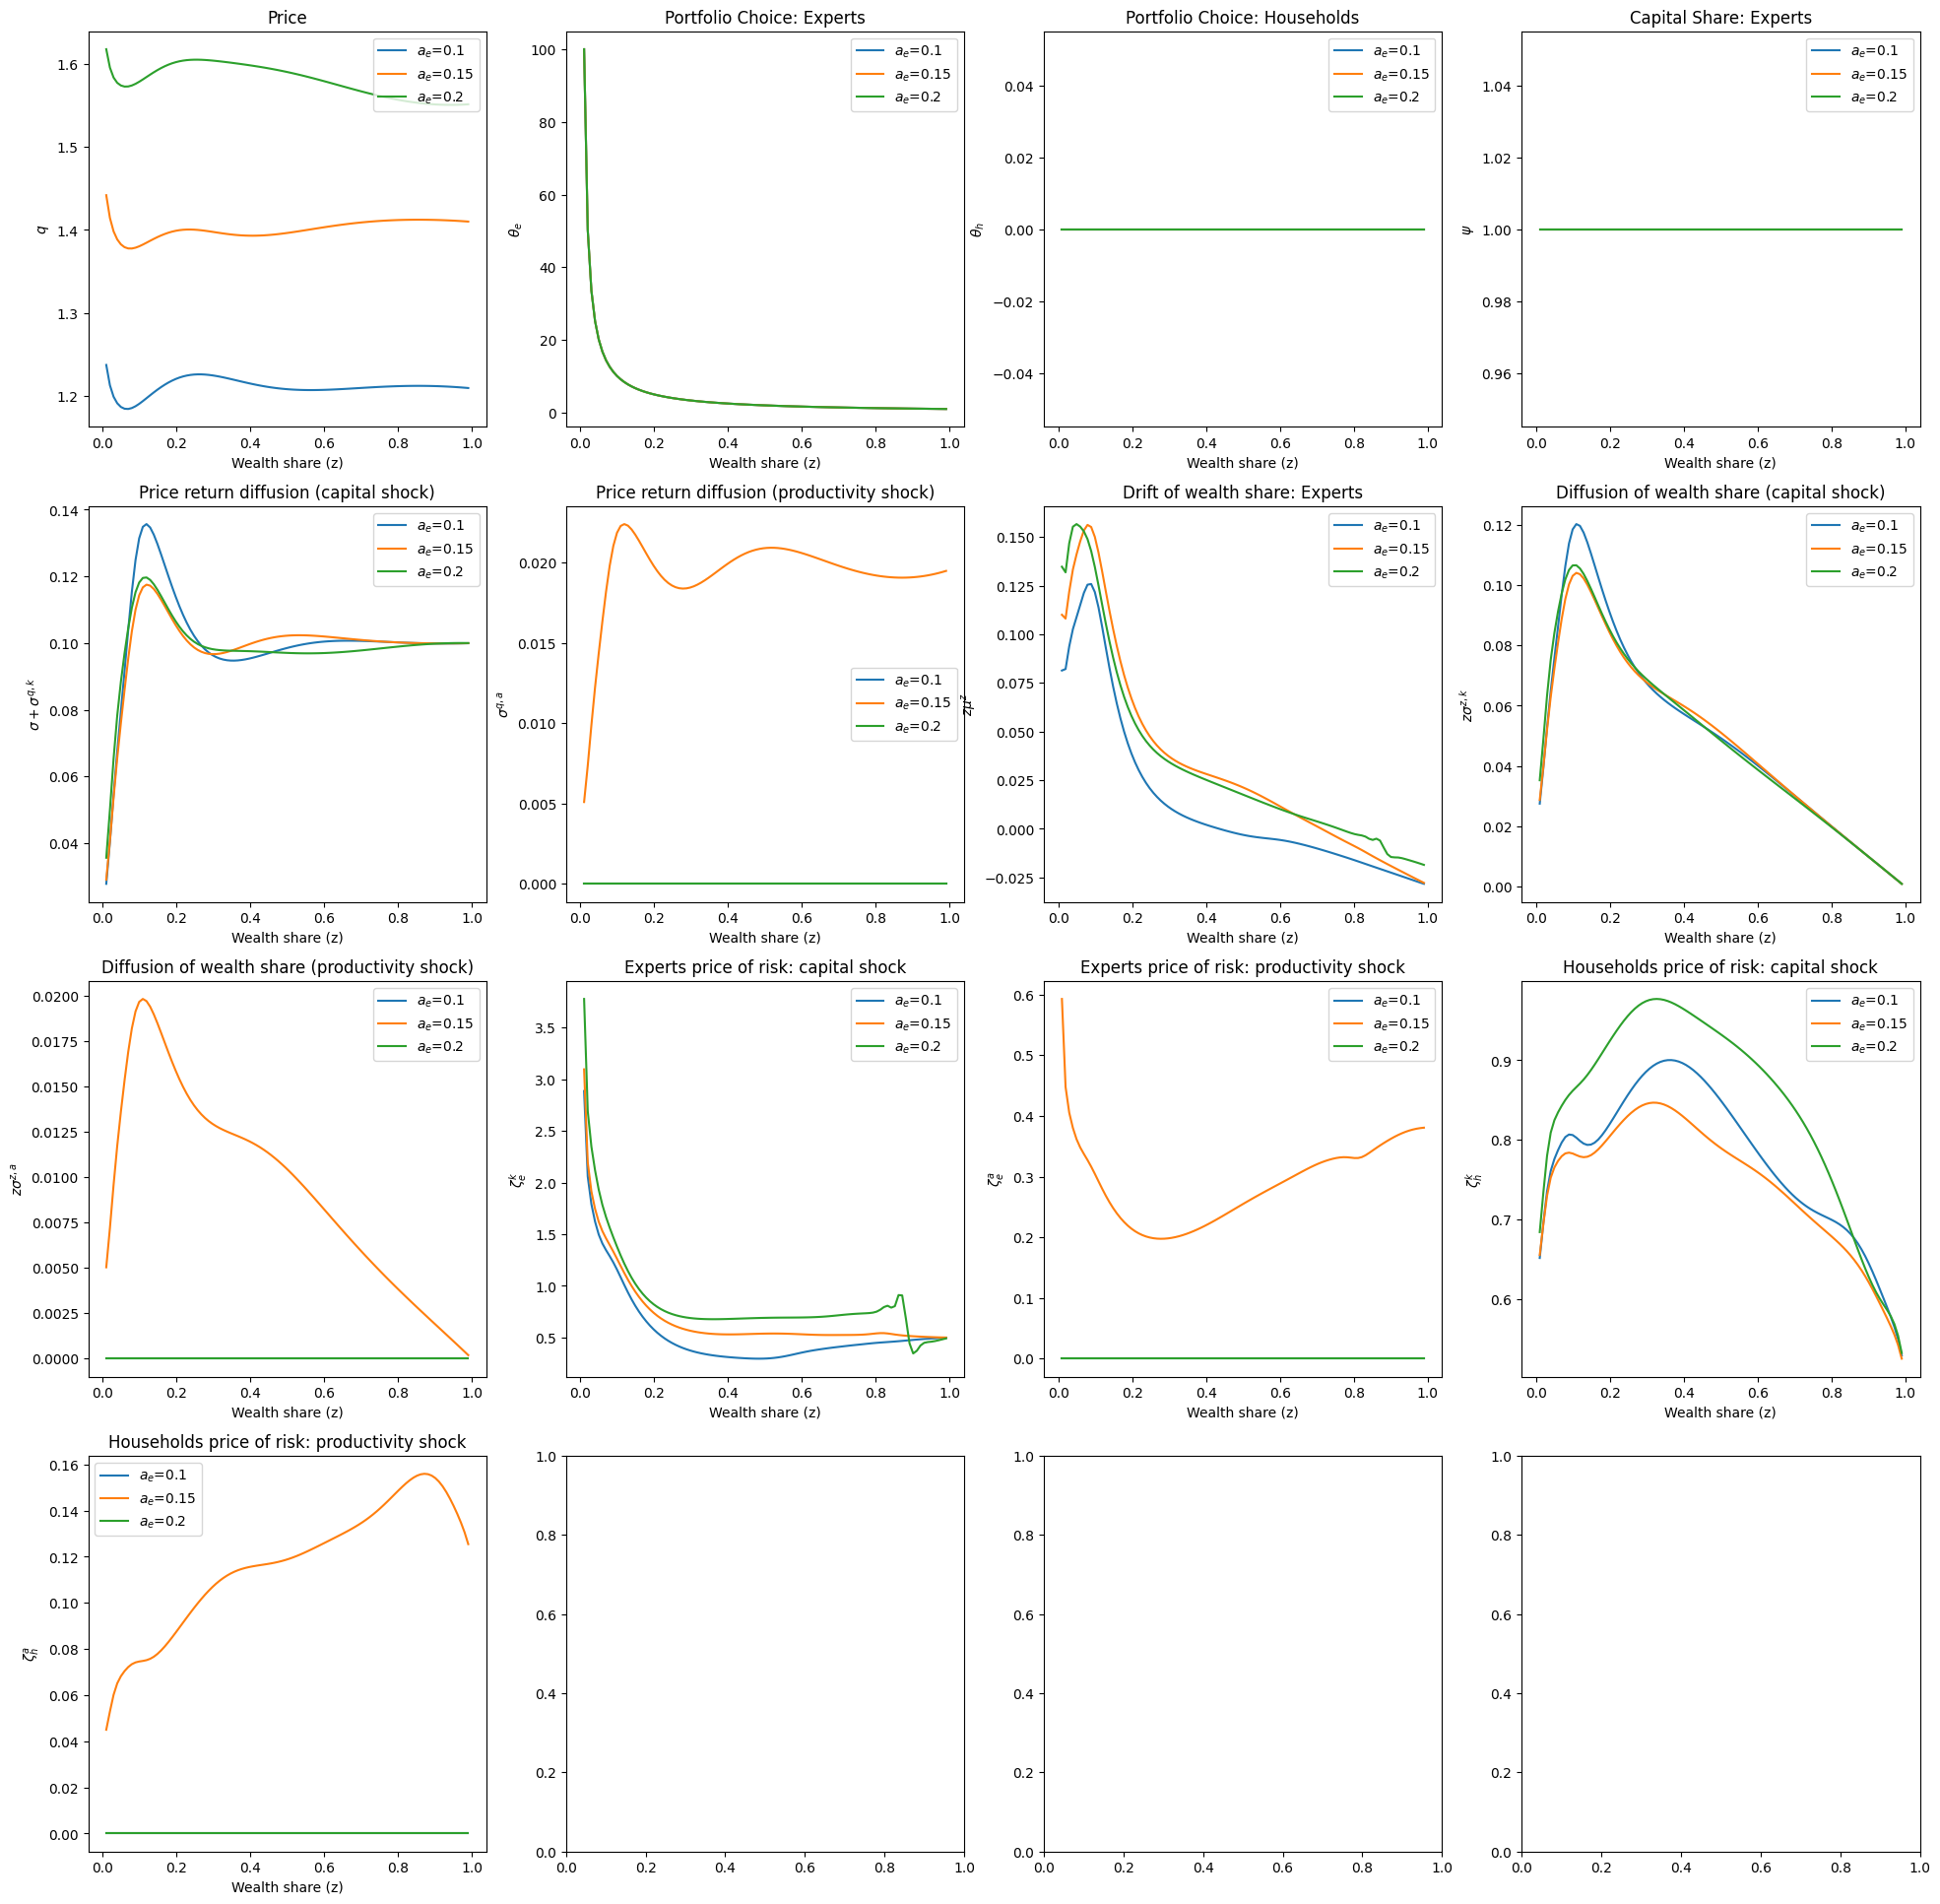

In [5]:
set_seeds(0)
pde_model = PDEModel("cd2d",
                     {"batch_size": 50, "num_epochs": 20000, "optimizer_type": OptimizerType.Adam, "sampling_method": SamplingMethod.FixedGrid,
                      "loss_soft_attention": True},
                     latex_var_map)
pde_model.set_state(["z", "ae"], {"z": [z_min, z_max], "ae": [a_min, a_max]})
pde_model.add_agents(["Je", "Jh"],
                     {"Je": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "Jh": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                     })
pde_model.add_endogs(["q"],
                     {"q": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4}
                      })
pde_model.add_params(params)

pde_model.add_equation(r"$\iota &= \frac{q - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi &= \frac{\log ( q)}{\kappa}$")
pde_model.add_equation(r"$\hat{c}_e &= \rho$")
pde_model.add_equation(r"$\hat{c}_h &= \rho$")
pde_model.add_equation(r"$\mu_{ae} &= p * (\hat{a_e} - a_e)$")
pde_model.add_equation(r"$\sigma_{ae} &= v * (fu - a_e) * (a_e - fl)$")
pde_model.add_equation(r"$\theta_e &= \frac{\underline{\chi}}{z}$")
pde_model.add_equation(r"$\theta_h &= \frac{1 - \underline{\chi}}{1 - z}$")
pde_model.add_equation(r"$\sigma^{q,k} &= \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} - z)} - \sigma$")
pde_model.add_equation(r"$\sigma^{q,a} &= \frac{\frac{1}{q} * \frac{\partial q}{\partial a_e} * \sigma_{ae}}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\underline{\chi} - z)}$")
pde_model.add_equation(r"$\sigma^{q,k,1} &= \sigma + \sigma^{q,k}$")
pde_model.add_equation(r"$\sigma^{z,k} &= \left(\theta_e - 1\right) * \sigma^{q,k,1}$")
pde_model.add_equation(r"$\sigma^{z,a} &= \left(\theta_e - 1\right) * \sigma^{q,a}$")
pde_model.add_equation(r"$\sigma_e^{J,k} &= \frac{1}{J_e} * \frac{\partial J_e}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_h^{J,k} &= \frac{1}{J_h} * \frac{\partial J_h}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_e^{J,a} &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial a_e} * \sigma_{ae} + \frac{\partial J_e}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\sigma_h^{J,a} &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial a_e} * \sigma_{ae} + \frac{\partial J_h}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\zeta_e^k &= -(1-\gamma) * \sigma_e^{J,k} + \sigma^{z,k} + \sigma^{q,k} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_e^a &= -(1-\gamma) * \sigma_e^{J,a} + \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_h^k &= -(1-\gamma) * \sigma_h^{J,k} - \frac{z}{1-z} * \sigma^{z,k} + \sigma^{q,k,1} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_h^a &= -(1-\gamma) * \sigma_h^{J,a} - \frac{z}{1-z} * \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_e^1 &= \zeta_e^k + \phi * \zeta_e^a$")
pde_model.add_equation(r"$\zeta_h^1 &= \zeta_h^k + \phi * \zeta_h^a$")
pde_model.add_equation(r"$\zeta_e^2 &= \zeta_e^a + \phi * \zeta_e^k$")
pde_model.add_equation(r"$\zeta_h^2 &= \zeta_h^a + \phi * \zeta_h^k$")
pde_model.add_equation(r"$\epsilon_e &= \sigma^{q,k,1} * \zeta_e^1 + \sigma^{q,a} * \zeta_e^2$")
pde_model.add_equation(r"$\epsilon_h &= \sigma^{q,k,1} * \zeta_h^1 + \sigma^{q,a} * \zeta_h^2$")
pde_model.add_equation(r"$\mu^z &= \frac{a_e - \iota}{q} - \hat{c}_e+ (\theta_e - 1) * (\sigma^{q,k,1} * (\zeta_e^1 - \sigma^{q,k,1}) + \sigma^{q,a} * (\zeta_e^2 - \sigma^{q,a}) - 2 * \phi * \sigma^{q,k,1} * \sigma^{q,a})+ (1-\underline{\chi}) * (\sigma^{q,k,1} * (\zeta_e^1 - \zeta_h^1) + \sigma^{q,a} * (\zeta_e^2 - \zeta_h^2)) + \frac{\lambda_d}{z} * (\bar{z} - z)$")
pde_model.add_equation(r"$\mu^q &= \frac{1}{q} * \left( \frac{\partial q}{\partial z} * \mu^z * z + \frac{\partial q}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2 q}{\partial z^2} * z^2 * ((\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k} * \sigma^{z,a})\right)+ \frac{1}{q} * \left( \frac{1}{2} * \frac{\partial^2 q}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 q}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a})  * \sigma_{ae} * z\right)$")
pde_model.add_equation(r"$\mu_e^J &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial z} * \mu^z * z + \frac{\partial J_e}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_e}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) \right)+ \frac{1}{J_e} * \left(\frac{1}{2} * \frac{\partial^2 J_e}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_e}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z \right)$")
pde_model.add_equation(r"$\mu_h^J &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial z} * \mu^z * z + \frac{\partial J_h}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_h}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) \right)+ \frac{1}{J_h} * \left(\frac{1}{2} * \frac{\partial^2 J_h}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_h}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z \right)$")
pde_model.add_equation(r"$\mu_e^R &= \frac{a_e - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$\mu_h^R &= \frac{a_h - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$r &= \mu_e^R - \underline{\chi} * \epsilon_e - (1-\underline{\chi}) * \epsilon_h$")
pde_model.add_equation(r"zmuz = z * muz")
pde_model.add_equation(r"zsigzk = z * sigzk")
pde_model.add_equation(r"zsigza = z * sigza")

pde_model.add_endog_equation(r"$\rho * q &= a_e - \iota$")
pde_model.add_constraint(r"$\frac{a_e - a_h}{q}$",
                         Comparator.GEQ,
                         r"$\underline{\chi} * (\epsilon_e - \epsilon_h)$")

pde_model.add_hjb_equation(r"$\rho * (\log(\rho) - \log(J_e) + \log(q * z)) + \Phi - \delta - (\gamma - 1) * (\sigma_e^{J,k} * \sigma + \phi * \sigma * \sigma_e^{J,a})-\frac{\gamma}{2} * ((\sigma_e^{J,k})^2 + (\sigma_e^{J,a})^2 + 2*\phi * \sigma_e^{J,k} * \sigma_e^{J,a} + \sigma^2) - \mu_e^J$")
pde_model.add_hjb_equation(r"$\rho * (\log(\rho) - \log(J_h) + \log(q * (1-z))) + \Phi - \delta - (\gamma - 1) * (\sigma_h^{J,k} * \sigma + \phi * \sigma * \sigma_h^{J,a})-\frac{\gamma}{2} * ((\sigma_h^{J,k})^2 + (\sigma_h^{J,a})^2 + 2*\phi * \sigma_h^{J,k} * \sigma_h^{J,a} + \sigma^2) - \mu_h^J$")

print(pde_model)
if not os.path.exists(f"{base_model_dir}/region2.pt"):
    pde_model.train_model(base_model_dir, "region2.pt", True)
    pde_model.load_model(torch.load(f"{base_model_dir}/region2_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{base_model_dir}/region2_best.pt"))
    pde_model.eval_model(True)

res_dict2 = compute_func(pde_model, a_list, z_min, z_max, vars_to_plot)
plot_res(res_dict2, plot_args, a_list)

## Region 3
$\psi = 1$, but $\epsilon_e = \epsilon_h$

=============================Summary of Model cd2d==============================
Config: {
 "batch_size": 50,
 "num_epochs": 20000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid",
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": true
}
Latex Variable Mapping:
{
 "J_e": "Je",
 "J_h": "Jh",
 "\\psi": "psi",
 "\\iota": "iota",
 "\\Phi": "Phi",
 "\\hat{c}_e": "ce",
 "\\hat{c}_h": "ch",
 "\\mu_{ae}": "muae",
 "\\sigma_{ae}": "sigae",
 "\\theta_e": "thetae",
 "\\theta_h": "thetah",
 "\\sigma^{q,k}": "sigqk",
 "\\sigma^{q,a}": "sigqa",
 "\\sigma^{q,k,1}": "sigsigqk",
 "\\sigma^{z,k}": "sigzk",
 "\\sigma^{z,a}": "sigza",
 "\\sigma_e^{J,k}": "sigJe_k",
 "\\sigma_h^{J,k}": "sigJh_k",
 "\\sigma_e^{J,a}": "sigJe_a",
 "\\sigma_h^{J,a}": "sigJh_a",
 "\\zeta_e^k": "zetae_k",
 "\\zeta_e^a": "zetae_a",
 "\\zeta_h^k": "zetah_k",
 "\\zet

Total loss: 0.0001: 100%|██████████| 20000/20000 [2:01:30<00:00,  2.74it/s]  


training finished, total time :: 7290.808938026428
Best model saved to ./models/cd_2d_soft_attention//region3_best.pt if valid
Model saved to ./models/cd_2d_soft_attention//region3.pt


C:\Users\User\AppData\Local\Temp\ipykernel_3756\2591239402.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pde_model.load_model(torch.load(f"{base_model_dir}/region3_be

Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
total_loss: 0.0000


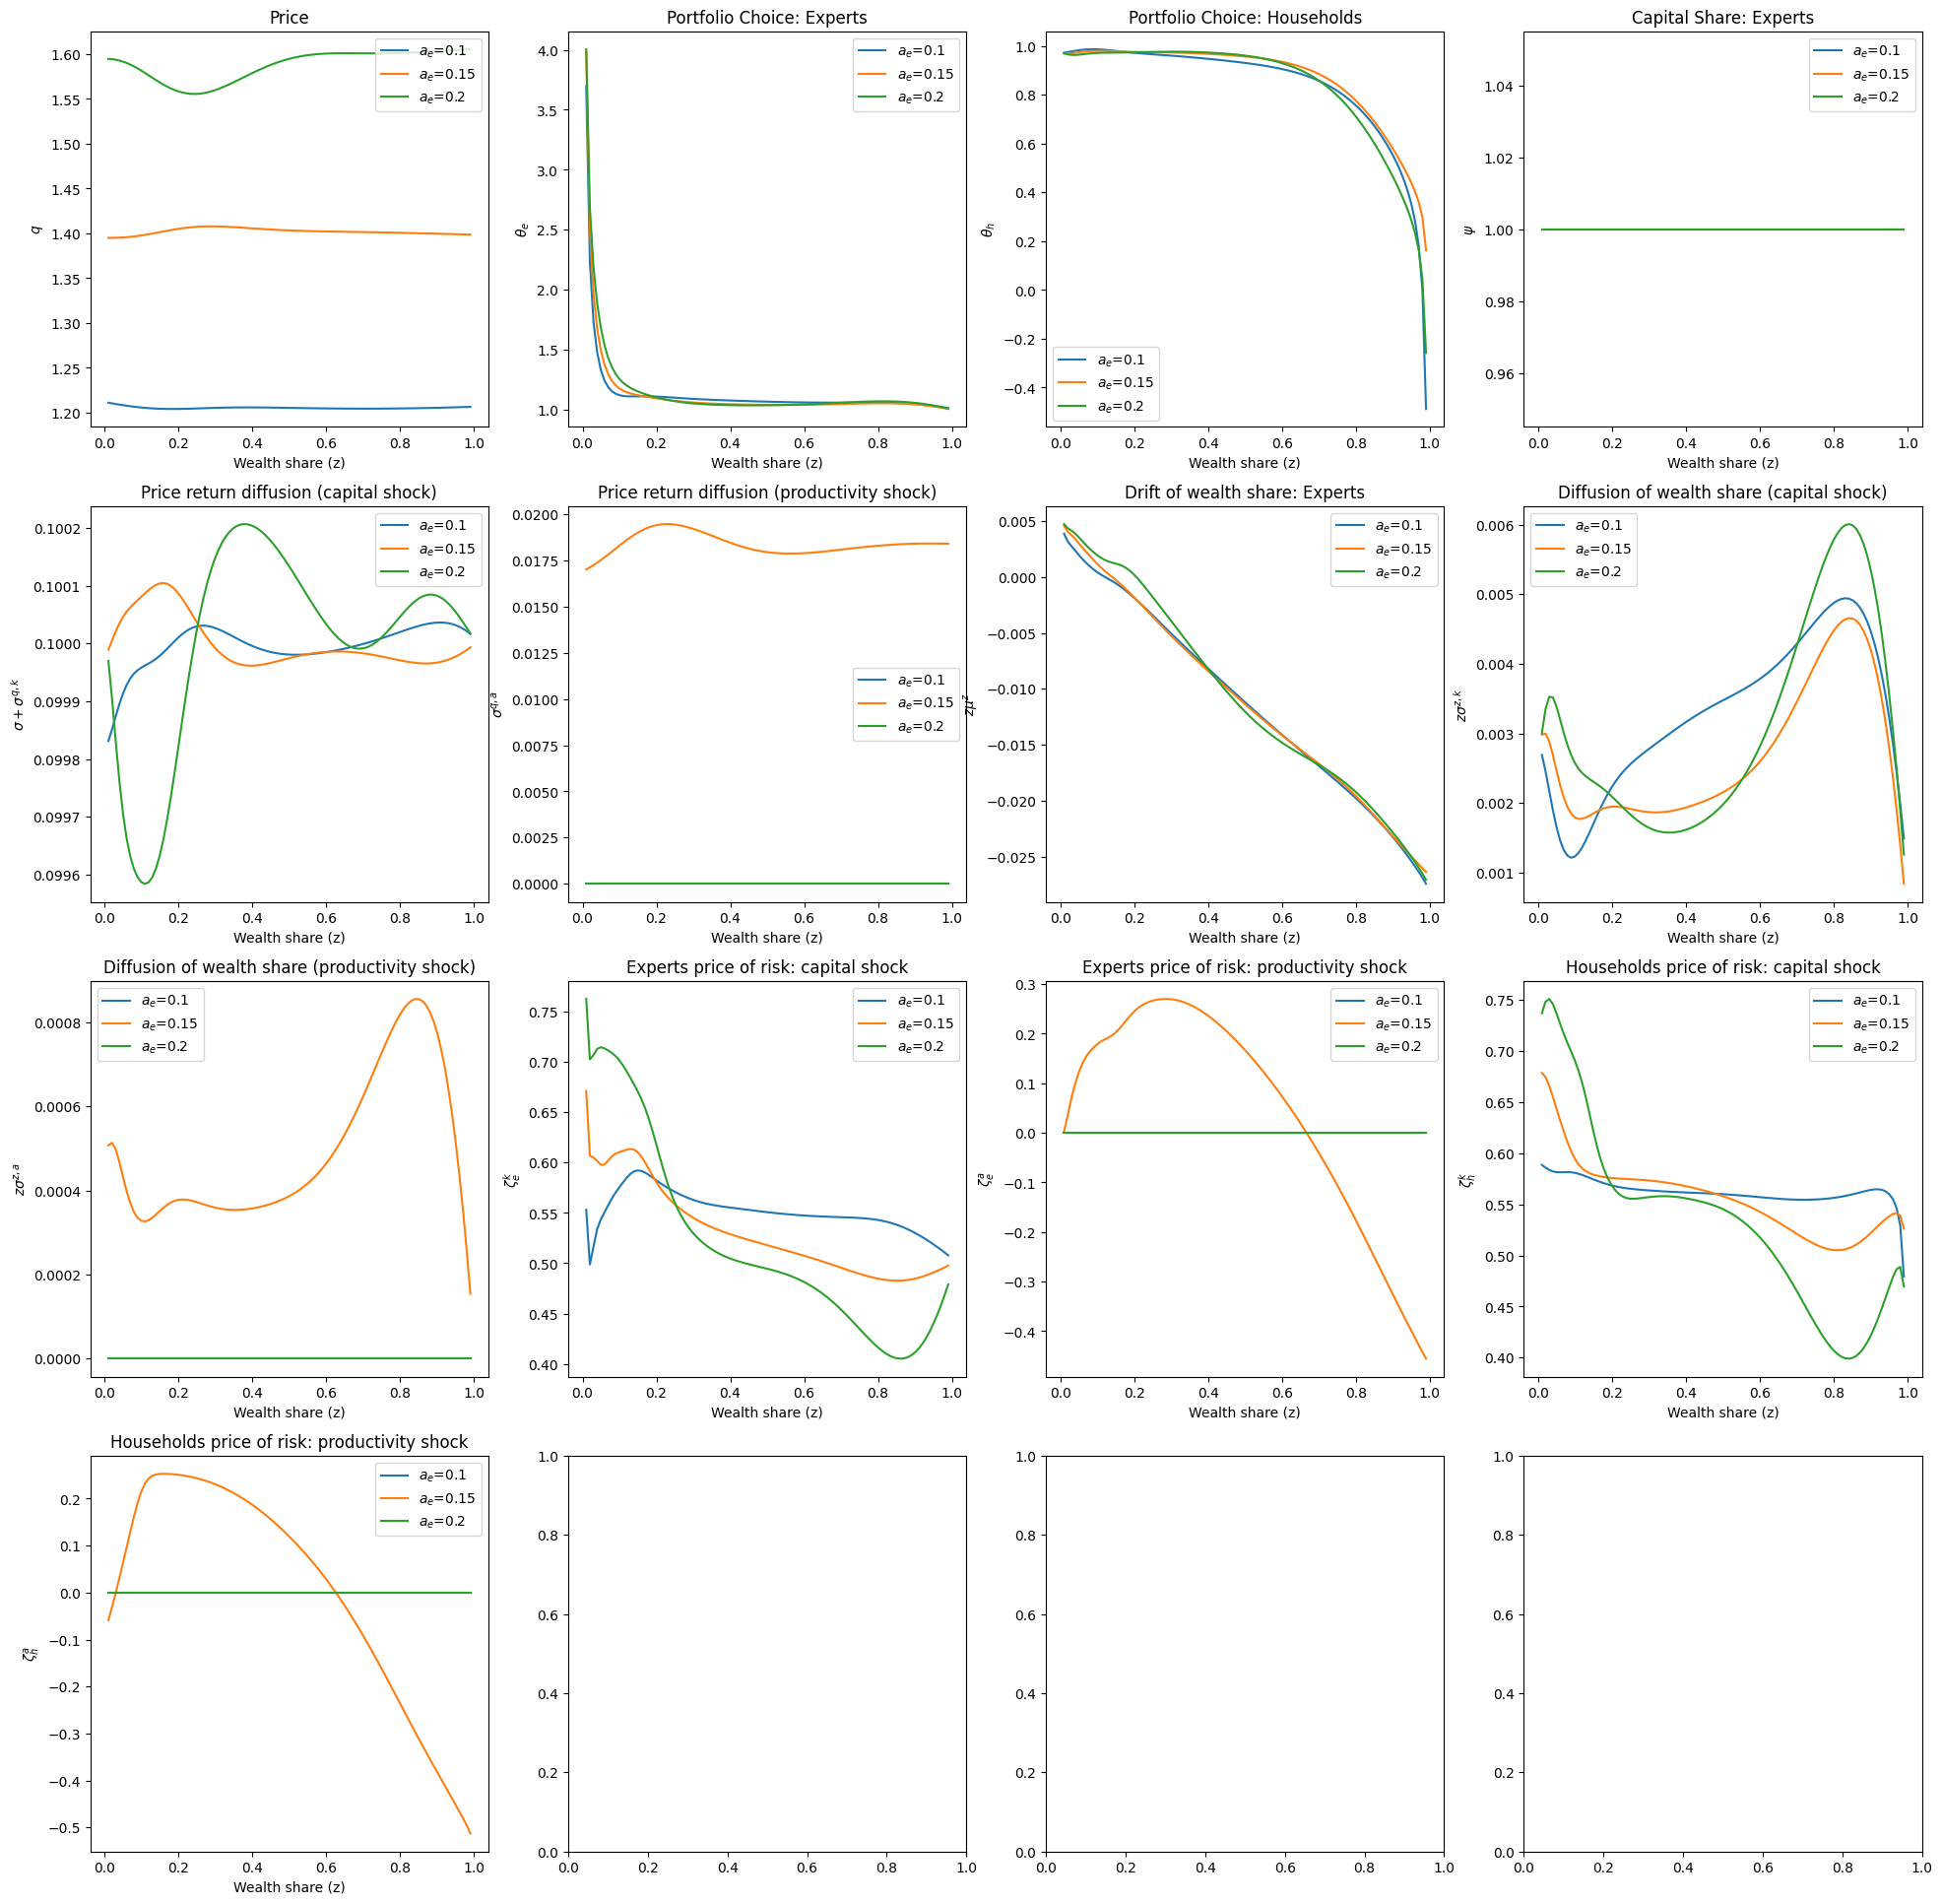

In [6]:
set_seeds(0)
pde_model = PDEModel("cd2d",
                     {"batch_size": 50, "num_epochs": 20000, "optimizer_type": OptimizerType.Adam, "sampling_method": SamplingMethod.FixedGrid,
                      "loss_soft_attention": True},
                     latex_var_map)
pde_model.set_state(["z", "ae"], {"z": [z_min, z_max], "ae": [a_min, a_max]})
pde_model.add_agents(["Je", "Jh"],
                     {"Je": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "Jh": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                     })
pde_model.add_endogs(["q", "chi"],
                     {"q": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4},
                      "chi": {"positive": True, "activation_type": ActivationType.SiLU, "hidden_units": [128] * 4}
                      })
pde_model.add_params(params)

pde_model.add_equation(r"$\iota &= \frac{q - 1}{\kappa}$")
pde_model.add_equation(r"$\Phi &= \frac{\log ( q)}{\kappa}$")
pde_model.add_equation(r"$\hat{c}_e &= \rho$")
pde_model.add_equation(r"$\hat{c}_h &= \rho$")
pde_model.add_equation(r"$\mu_{ae} &= p * (\hat{a_e} - a_e)$")
pde_model.add_equation(r"$\sigma_{ae} &= v * (fu - a_e) * (a_e - fl)$")
pde_model.add_equation(r"$\theta_e &= \frac{\chi}{z}$")
pde_model.add_equation(r"$\theta_h &= \frac{1 - \chi}{1 - z}$")
pde_model.add_equation(r"$\sigma^{q,k} &= \frac{\sigma}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\chi - z)} - \sigma$")
pde_model.add_equation(r"$\sigma^{q,a} &= \frac{\frac{1}{q} * \frac{\partial q}{\partial a_e} * \sigma_{ae}}{1 - \frac{1}{q} * \frac{\partial q}{\partial z} * (\chi - z)}$")
pde_model.add_equation(r"$\sigma^{q,k,1} &= \sigma + \sigma^{q,k}$")
pde_model.add_equation(r"$\sigma^{z,k} &= \left(\theta_e - 1\right) * \sigma^{q,k,1}$")
pde_model.add_equation(r"$\sigma^{z,a} &= \left(\theta_e - 1\right) * \sigma^{q,a}$")
pde_model.add_equation(r"$\sigma_e^{J,k} &= \frac{1}{J_e} * \frac{\partial J_e}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_h^{J,k} &= \frac{1}{J_h} * \frac{\partial J_h}{\partial z} * z * \sigma^{z,k}$")
pde_model.add_equation(r"$\sigma_e^{J,a} &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial a_e} * \sigma_{ae} + \frac{\partial J_e}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\sigma_h^{J,a} &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial a_e} * \sigma_{ae} + \frac{\partial J_h}{\partial z} * z * \sigma^{z,a} \right)$")
pde_model.add_equation(r"$\zeta_e^k &= -(1-\gamma) * \sigma_e^{J,k} + \sigma^{z,k} + \sigma^{q,k} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_e^a &= -(1-\gamma) * \sigma_e^{J,a} + \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_h^k &= -(1-\gamma) * \sigma_h^{J,k} - \frac{z}{1-z} * \sigma^{z,k} + \sigma^{q,k,1} + \gamma * \sigma$")
pde_model.add_equation(r"$\zeta_h^a &= -(1-\gamma) * \sigma_h^{J,a} - \frac{z}{1-z} * \sigma^{z,a} + \sigma^{q,a}$")
pde_model.add_equation(r"$\zeta_e^1 &= \zeta_e^k + \phi * \zeta_e^a$")
pde_model.add_equation(r"$\zeta_h^1 &= \zeta_h^k + \phi * \zeta_h^a$")
pde_model.add_equation(r"$\zeta_e^2 &= \zeta_e^a + \phi * \zeta_e^k$")
pde_model.add_equation(r"$\zeta_h^2 &= \zeta_h^a + \phi * \zeta_h^k$")
pde_model.add_equation(r"$\epsilon_e &= \sigma^{q,k,1} * \zeta_e^1 + \sigma^{q,a} * \zeta_e^2$")
pde_model.add_equation(r"$\epsilon_h &= \sigma^{q,k,1} * \zeta_h^1 + \sigma^{q,a} * \zeta_h^2$")
pde_model.add_equation(r"$\mu^z &= \frac{a_e - \iota}{q} - \hat{c}_e+ (\theta_e - 1) * (\sigma^{q,k,1} * (\zeta_e^1 - \sigma^{q,k,1}) + \sigma^{q,a} * (\zeta_e^2 - \sigma^{q,a}) - 2 * \phi * \sigma^{q,k,1} * \sigma^{q,a})+ (1-\chi) * (\sigma^{q,k,1} * (\zeta_e^1 - \zeta_h^1) + \sigma^{q,a} * (\zeta_e^2 - \zeta_h^2)) + \frac{\lambda_d}{z} * (\bar{z} - z)$")
pde_model.add_equation(r"$\mu^q &= \frac{1}{q} * \left( \frac{\partial q}{\partial z} * \mu^z * z + \frac{\partial q}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2 q}{\partial z^2} * z^2 * ((\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k} * \sigma^{z,a})\right)+ \frac{1}{q} * \left( \frac{1}{2} * \frac{\partial^2 q}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 q}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a})  * \sigma_{ae} * z\right)$")
pde_model.add_equation(r"$\mu_e^J &= \frac{1}{J_e} * \left(\frac{\partial J_e}{\partial z} * \mu^z * z + \frac{\partial J_e}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_e}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) \right)+ \frac{1}{J_e} * \left(\frac{1}{2} * \frac{\partial^2 J_e}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_e}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z \right)$")
pde_model.add_equation(r"$\mu_h^J &= \frac{1}{J_h} * \left(\frac{\partial J_h}{\partial z} * \mu^z * z + \frac{\partial J_h}{\partial a_e} * \mu_{ae} + \frac{1}{2} * \frac{\partial^2  J_h}{\partial z^2} * z^2 * \left( (\sigma^{z,k})^2 + (\sigma^{z,a})^2 + 2 * \phi * \sigma^{z,k}* \sigma^{z,a} \right) \right)+ \frac{1}{J_h} * \left(\frac{1}{2} * \frac{\partial^2 J_h}{\partial a_e^2} * \sigma_{ae}^2 + \frac{\partial^2 J_h}{\partial z \partial a_e} * (\phi * \sigma^{z,k} + \sigma^{z,a}) * \sigma_{ae} * z \right)$")
pde_model.add_equation(r"$\mu_e^R &= \frac{a_e - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$\mu_h^R &= \frac{a_h - \iota}{q} + \Phi - \delta + \mu^q + \sigma * \sigma^{q,k} + \phi * \sigma * \sigma^{q,a}$")
pde_model.add_equation(r"$r &= \mu_e^R - \chi * \epsilon_e - (1-\chi) * \epsilon_h$")
pde_model.add_equation(r"zmuz = z * muz")
pde_model.add_equation(r"zsigzk = z * sigzk")
pde_model.add_equation(r"zsigza = z * sigza")

pde_model.add_endog_equation(r"$\rho * q &= a_e - \iota$")
pde_model.add_endog_equation(r"$\epsilon_e &= \epsilon_h$")

pde_model.add_hjb_equation(r"$\rho * (\log(\rho) - \log(J_e) + \log(q * z)) + \Phi - \delta - (\gamma - 1) * (\sigma_e^{J,k} * \sigma + \phi * \sigma * \sigma_e^{J,a})-\frac{\gamma}{2} * ((\sigma_e^{J,k})^2 + (\sigma_e^{J,a})^2 + 2*\phi * \sigma_e^{J,k} * \sigma_e^{J,a} + \sigma^2) - \mu_e^J$")
pde_model.add_hjb_equation(r"$\rho * (\log(\rho) - \log(J_h) + \log(q * (1-z))) + \Phi - \delta - (\gamma - 1) * (\sigma_h^{J,k} * \sigma + \phi * \sigma * \sigma_h^{J,a})-\frac{\gamma}{2} * ((\sigma_h^{J,k})^2 + (\sigma_h^{J,a})^2 + 2*\phi * \sigma_h^{J,k} * \sigma_h^{J,a} + \sigma^2) - \mu_h^J$")

print(pde_model)
if not os.path.exists(f"{base_model_dir}/region3.pt"):
    pde_model.train_model(base_model_dir, "region3.pt", True)
    pde_model.load_model(torch.load(f"{base_model_dir}/region3_best.pt"))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{base_model_dir}/region3_best.pt"))
    pde_model.eval_model(True)

res_dict3 = compute_func(pde_model, a_list, z_min, z_max, vars_to_plot)
plot_res(res_dict3, plot_args, a_list)

## Final Plots

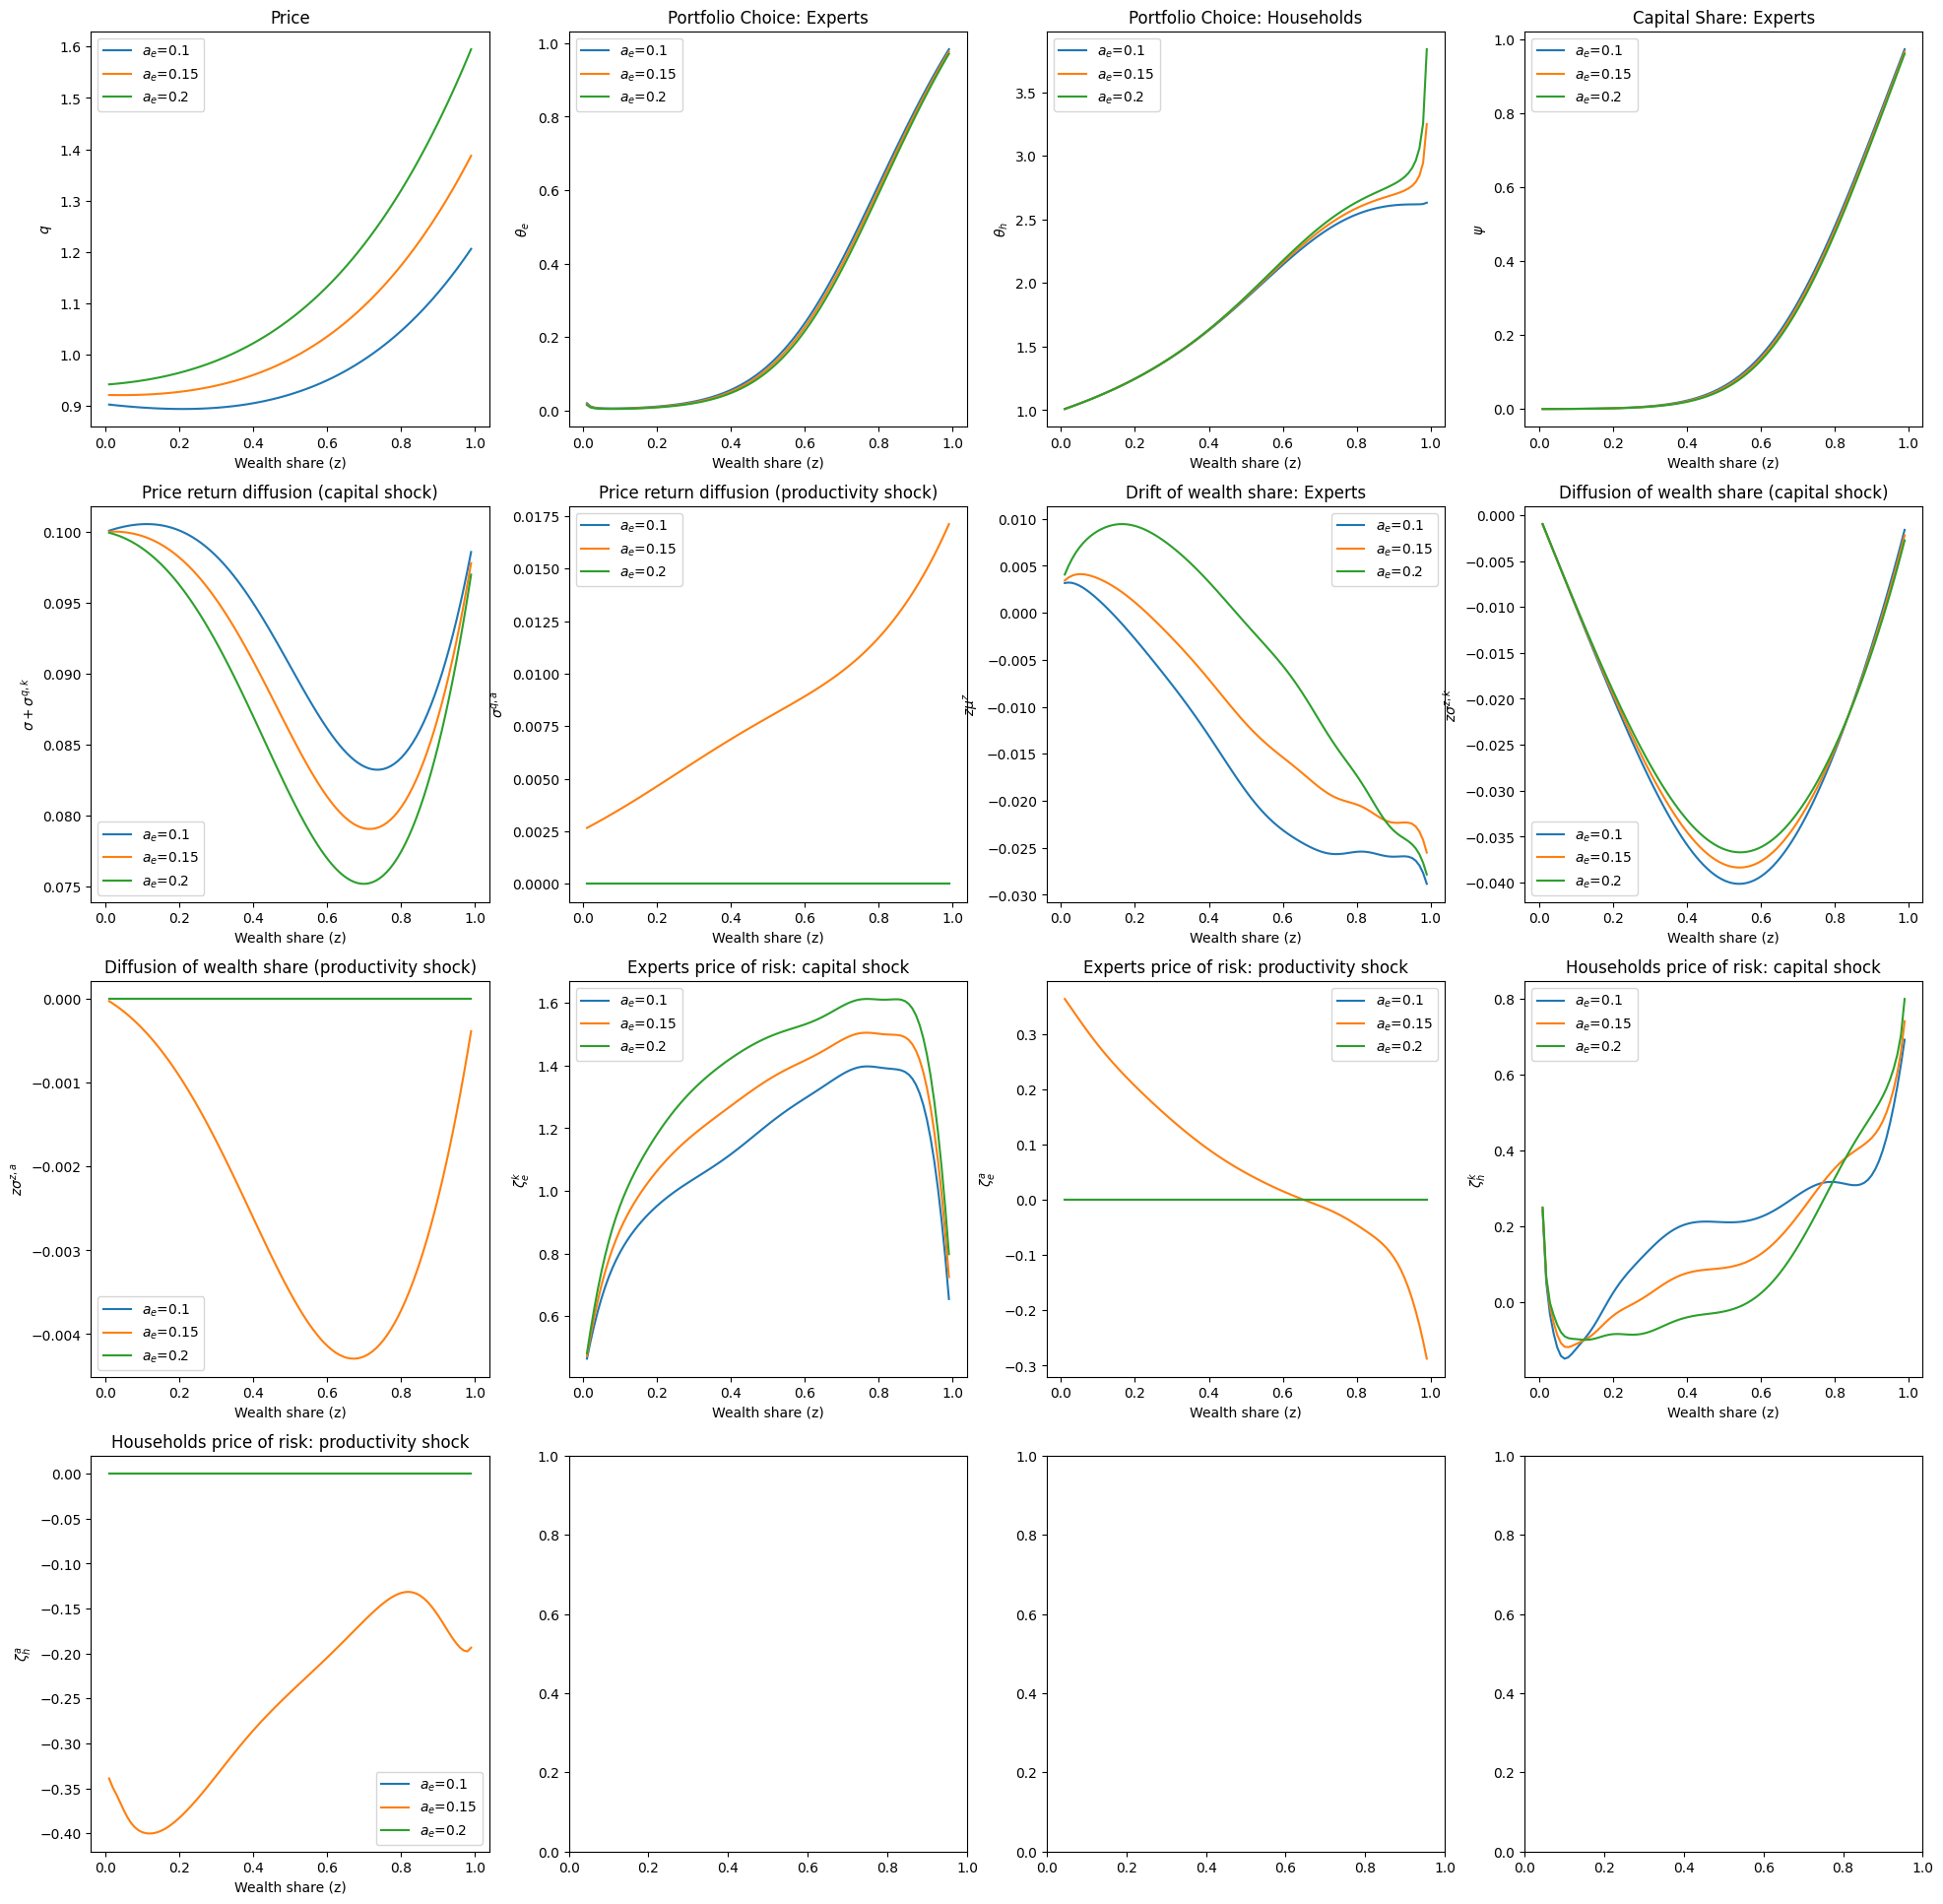

In [7]:
final_plot_dict = {}
for a in a_list:
    index_region1 = (res_dict1[f"psi_{a}"] < 1)
    index_region2 = (res_dict1[f"psi_{a}"] >= 1) & (res_dict2[f"epse_{a}"] > res_dict2[f"epsh_{a}"])
    index_region3 = (res_dict1[f"psi_{a}"] >= 1) & (res_dict2[f"epse_{a}"] <= res_dict2[f"epsh_{a}"])
    for k in plot_args:
        final_plot_dict[f"{k}_{a}"] = res_dict1[f"{k}_{a}"] * index_region1 + res_dict2[f"{k}_{a}"] * index_region2 + res_dict3[f"{k}_{a}"] * index_region3
final_plot_dict["x_plot"] = res_dict1["x_plot"]
plot_res(final_plot_dict, plot_args, a_list)